In [1]:
import os
import time
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import community
import networkx as nx
import cpnet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [2]:
token_name = 'LQTY'
start_date = '2021-04-09'
end_date = '2022-04-09'
DATA_DIR = f'../Data/{token_name}_{start_date}-{end_date}'
FIGURE_DIR = f'../Figure/{token_name}_{start_date}-{end_date}'

if os.path.exists(DATA_DIR) is False:
    os.makedirs(DATA_DIR)
    
if os.path.exists(FIGURE_DIR) is False:
    os.makedirs(FIGURE_DIR)

In [3]:
raw_tx = pd.read_csv(f'{DATA_DIR}/raw_tx.csv')
agg_tx = pd.read_csv(f'{DATA_DIR}/agg_tx.csv')
network_fea = pd.read_csv(f'{DATA_DIR}/network_fea.csv')
core_days_cnt = pd.read_csv(f'{DATA_DIR}/core_days_cnt.csv')

## Visualization

#### Distribution on significant & insignificant days 

In [4]:
sig_T = network_fea[network_fea['significance'] < 0.05]
sig_F = network_fea[network_fea['significance'] >= 0.05]

print(f'Number of significant days VS insignificant days: {sig_T.shape[0]} | {sig_F.shape[0]}')

sig_T.head()

Number of significant days VS insignificant days: 309 | 56


,timestamp,num_edges,num_nodes,degree_mean,degree_std,top10_degree_mean,top10_degree_std,top10_degree_ratio,degree_centrality_mean,degree_centrality_std,...,transitivity,eigenvector_centrality_mean,eigenvector_centrality_atd,closeness_centrality_mean,closeness_centrality_std,num_components,giant_com_ratio,num_core,avg_core_neighbor,significance
0,2021-04-09,773,457,3.155361,16.431675,70.5,87.662135,22.342926,0.006920,0.036034,...,0.000474,0.032763,0.033388,0.347403,0.058551,2,0.995624,4,165.75,0.0
1,2021-04-10,817,477,3.194969,18.119500,76.0,101.132586,23.787402,0.006712,0.038066,...,0.000225,0.032503,0.032249,0.368076,0.062877,3,0.991614,4,183.00,0.0
2,2021-04-11,815,466,3.270386,17.536836,75.3,94.915805,23.024803,0.007033,0.037714,...,0.000409,0.032349,0.033158,0.363550,0.056408,2,0.995708,4,178.75,0.0
3,2021-04-12,777,468,3.141026,17.501813,73.2,96.443559,23.304490,0.006726,0.037477,...,0.000246,0.032609,0.032763,0.367068,0.058004,1,1.000000,4,173.50,0.0
4,2021-04-13,1006,598,3.173913,19.592074,93.2,121.172439,29.364384,0.005316,0.032818,...,0.000411,0.028208,0.029606,0.349980,0.078720,2,0.968227,4,220.00,0.0


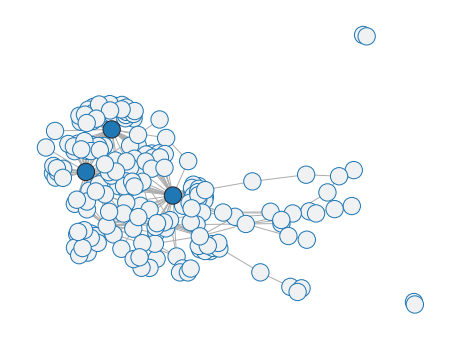

In [5]:
sample_sig_T_df = agg_tx[agg_tx['timestamp'] == '2021-06-27']

G = nx.from_pandas_edgelist(sample_sig_T_df, 'from_address', 'to_address', 'value', nx.Graph())

# Detecting discrete core-periphery structure
alg = cpnet.BE()        # Load the Borgatti-Everett algorithm
alg.detect(G)           # Feed the G as an input
x = alg.get_coreness()  # Get the coreness of nodes
c = alg.get_pair_id()   # Get the group membership of nodes

fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax, pos = cpnet.draw(G, c, x, ax)

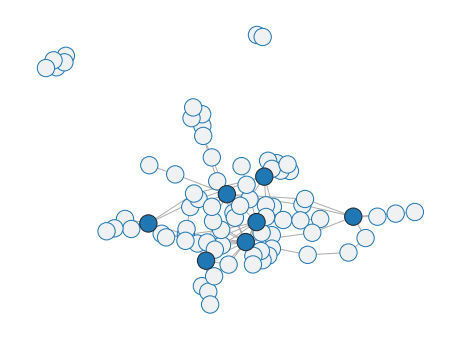

In [6]:
sample_sig_F_df = agg_tx[agg_tx['timestamp'] == '2022-02-02']

G = nx.from_pandas_edgelist(sample_sig_F_df, 'from_address', 'to_address', 'value', nx.Graph())

# Detecting discrete core-periphery structure
alg = cpnet.BE()        # Load the Borgatti-Everett algorithm
alg.detect(G)           # Feed the G as an input
x = alg.get_coreness()  # Get the coreness of nodes
c = alg.get_pair_id()   # Get the group membership of nodes

fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax, pos = cpnet.draw(G, c, x, ax)

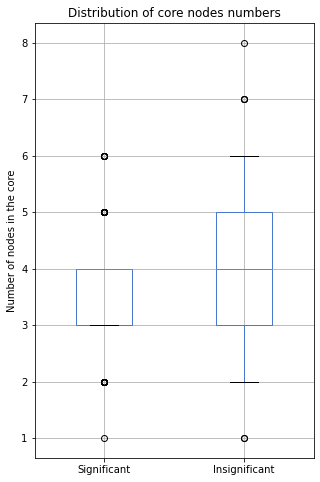

In [7]:
num_core_sig_T = sig_T['num_core']
num_core_sig_F = sig_F['num_core']

plt.style.use('seaborn-muted')
plt.figure(figsize=(5, 8))
dt = pd.DataFrame({'Significant':num_core_sig_T, 'Insignificant':num_core_sig_F})
dt.boxplot(widths = 0.4,whis=0.5)
plt.title('Distribution of core nodes numbers')
plt.ylabel('Number of nodes in the core')
plt.rc('font', size=13) # controls default text sizes
plt.savefig(f'{FIGURE_DIR}/Distribution_of_core_nodes_numbers')

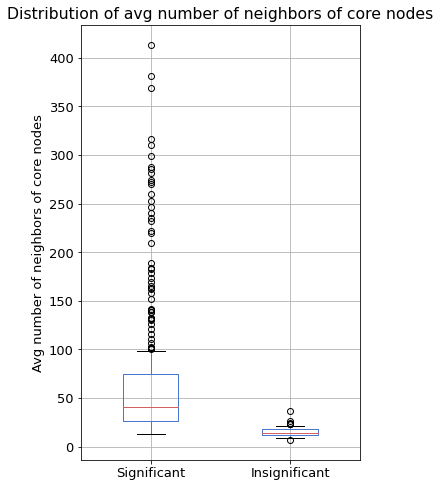

In [8]:
avg_core_neighbor_sig_T = sig_T['avg_core_neighbor']
avg_core_neighbor_sig_F = sig_F['avg_core_neighbor']

plt.figure(figsize=(5, 8))
dt = pd.DataFrame({'Significant':avg_core_neighbor_sig_T, 'Insignificant':avg_core_neighbor_sig_F})
dt.boxplot(widths = 0.4,whis=0.5)
plt.title('Distribution of avg number of neighbors of core nodes')
plt.ylabel('Avg number of neighbors of core nodes')
plt.rc('font', size=13)
plt.savefig(f'{FIGURE_DIR}/Distribution_of_avg_number_of_neighbors_of_core_nodes')

#### Core days count distribution of CA and EOA

In [9]:
def count_unique_addresses(x):
    addresses = list(x['from_address']) + list(x['to_address'])
    return pd.DataFrame({'address_count': [len(set(addresses))]})

network_fea['address_count'] = raw_tx.groupby('timestamp').apply(count_unique_addresses).reset_index().drop(columns=['level_1'])['address_count']
# network_fea['address_count'] = pd.merge(network_fea,
#                                         raw_tx.groupby('timestamp').apply(count_unique_addresses).reset_index().drop(columns=['level_1']),
#                                         on='timestamp',
#                                         how='left')
network_fea['value'] = agg_tx['value']
network_fea

,timestamp,num_edges,num_nodes,degree_mean,degree_std,top10_degree_mean,top10_degree_std,top10_degree_ratio,degree_centrality_mean,degree_centrality_std,...,eigenvector_centrality_atd,closeness_centrality_mean,closeness_centrality_std,num_components,giant_com_ratio,num_core,avg_core_neighbor,significance,address_count,value
0,2021-04-09,773,457,3.155361,16.431675,70.5,87.662135,22.342926,0.006920,0.036034,...,0.033388,0.347403,0.058551,2,0.995624,4,165.750000,0.000000,457,7.805301e+19
1,2021-04-10,817,477,3.194969,18.119500,76.0,101.132586,23.787402,0.006712,0.038066,...,0.032249,0.368076,0.062877,3,0.991614,4,183.000000,0.000000,477,5.643006e+20
2,2021-04-11,815,466,3.270386,17.536836,75.3,94.915805,23.024803,0.007033,0.037714,...,0.033158,0.363550,0.056408,2,0.995708,4,178.750000,0.000000,466,1.064666e+20
3,2021-04-12,777,468,3.141026,17.501813,73.2,96.443559,23.304490,0.006726,0.037477,...,0.032763,0.367068,0.058004,1,1.000000,4,173.500000,0.000000,468,1.467666e+20
4,2021-04-13,1006,598,3.173913,19.592074,93.2,121.172439,29.364384,0.005316,0.032818,...,0.029606,0.349980,0.078720,2,0.968227,4,220.000000,0.000000,598,1.010541e+21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2022-04-04,52,48,2.083333,2.139250,4.9,3.330165,2.352000,0.044326,0.045516,...,0.111758,0.207272,0.071222,3,0.916667,2,11.000000,0.237692,48,1.030034e+18
361,2022-04-05,122,100,2.340000,3.219379,9.6,6.343501,4.102564,0.023636,0.032519,...,0.083846,0.181520,0.084633,7,0.830000,5,14.000000,0.149650,100,4.000000e+19
362,2022-04-06,143,103,2.640777,3.861320,11.3,8.013114,4.279044,0.025890,0.037856,...,0.081302,0.250886,0.066685,2,0.970874,8,10.250000,0.733166,103,6.000000e+19
363,2022-04-07,127,96,2.458333,3.390909,10.1,6.347440,4.108475,0.025877,0.035694,...,0.084822,0.199838,0.072103,4,0.916667,5,14.400000,0.092812,96,7.951866e+19


In [10]:
print(f'CA vs EOA: {core_days_cnt_CA.shape[0]} | {core_days_cnt_EOA.shape[0]}')

NameError: name 'core_days_cnt_CA' is not defined

In [11]:
plt.style.use('seaborn-muted')
plt.figure(figsize=(8, 8))
dt = pd.DataFrame({'CA':core_days_cnt_CA['core_days_cnt'], 'EOA':core_days_cnt_EOA['core_days_cnt']})
dt.boxplot(widths = 0.4,whis=0.5)
plt.title('Core days count distribution of CA and EOA')
plt.ylabel('Number of days becoming core')
plt.rc('font', size=15)
plt.savefig(f'{FIGURE_DIR}/Core_days_count_distribution_of_CA_and_EOA')

NameError: name 'core_days_cnt_CA' is not defined

<Figure size 576x576 with 0 Axes>

#### Network Dynamics

In [15]:
network_fea.rename(columns={'significance': 'cp_pvalue'}, inplace=True)

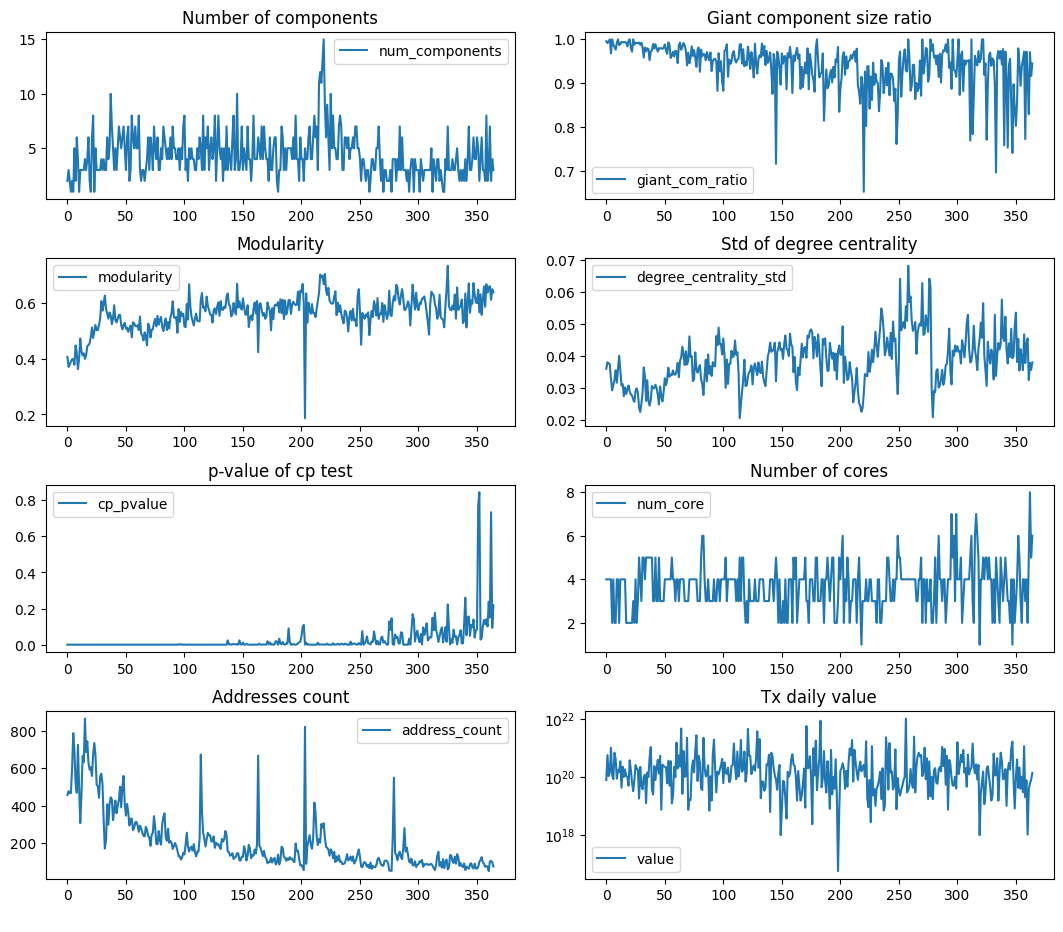

In [17]:
fig,axes = plt.subplots(4,2)
plt.style.use('default')

# Number of components
ax = network_fea[['num_components']].plot(ax=axes[0,0], figsize=(13,10), grid=False, title='Number of components', xlabel=' ')
# ax.set_yscale('log')

# Gaint component ratio
network_fea[['giant_com_ratio']].plot(ax=axes[0,1], figsize=(13,7), grid=False, title='Giant component size ratio', xlabel=' ')

# Modularity
network_fea[['modularity']].plot(ax=axes[1,0], figsize=(13,7), grid=False, title='Modularity', xlabel=' ')

# Std of degree centrality
network_fea[['degree_centrality_std']].plot(ax=axes[1,1], figsize=(13,7), grid=False, title='Std of degree centrality',xlabel=' ')

# p-value of cp test
network_fea[['cp_pvalue']].plot(ax=axes[2,0], figsize=(13,11), grid=False, title='p-value of cp test', xlabel=' ')

# Number of cores
network_fea[['num_core']].plot(ax=axes[2,1], figsize=(13,11), grid=False, title='Number of cores', xlabel=' ')

# Addresses count
network_fea[['address_count']].plot(ax=axes[3,0], figsize=(13,11), grid=False, title='Addresses count', xlabel=' ')

# Tx daily value
ax = network_fea[['value']].plot(ax=axes[3,1], figsize=(13,11), grid=False, title='Tx daily value', xlabel=' ')
ax.set_yscale('log')

plt.subplots_adjust(wspace =0.15, hspace =0.35)
plt.savefig(f'{FIGURE_DIR}/Network_Dynamics')

#### Correlations of network features

In [18]:
network_fea_cor = network_fea[['num_components', 'giant_com_ratio', 'modularity', 'degree_centrality_std', 'significance']].corr()
network_fea_cor

,num_components,giant_com_ratio,modularity,degree_centrality_std,significance
num_components,1.000000,-0.497426,0.219945,-0.375062,-0.145952
giant_com_ratio,-0.497426,1.000000,-0.501614,-0.145061,-0.165643
modularity,0.219945,-0.501614,1.000000,-0.027292,0.249895
degree_centrality_std,-0.375062,-0.145061,-0.027292,1.000000,0.137404
significance,-0.145952,-0.165643,0.249895,0.137404,1.000000


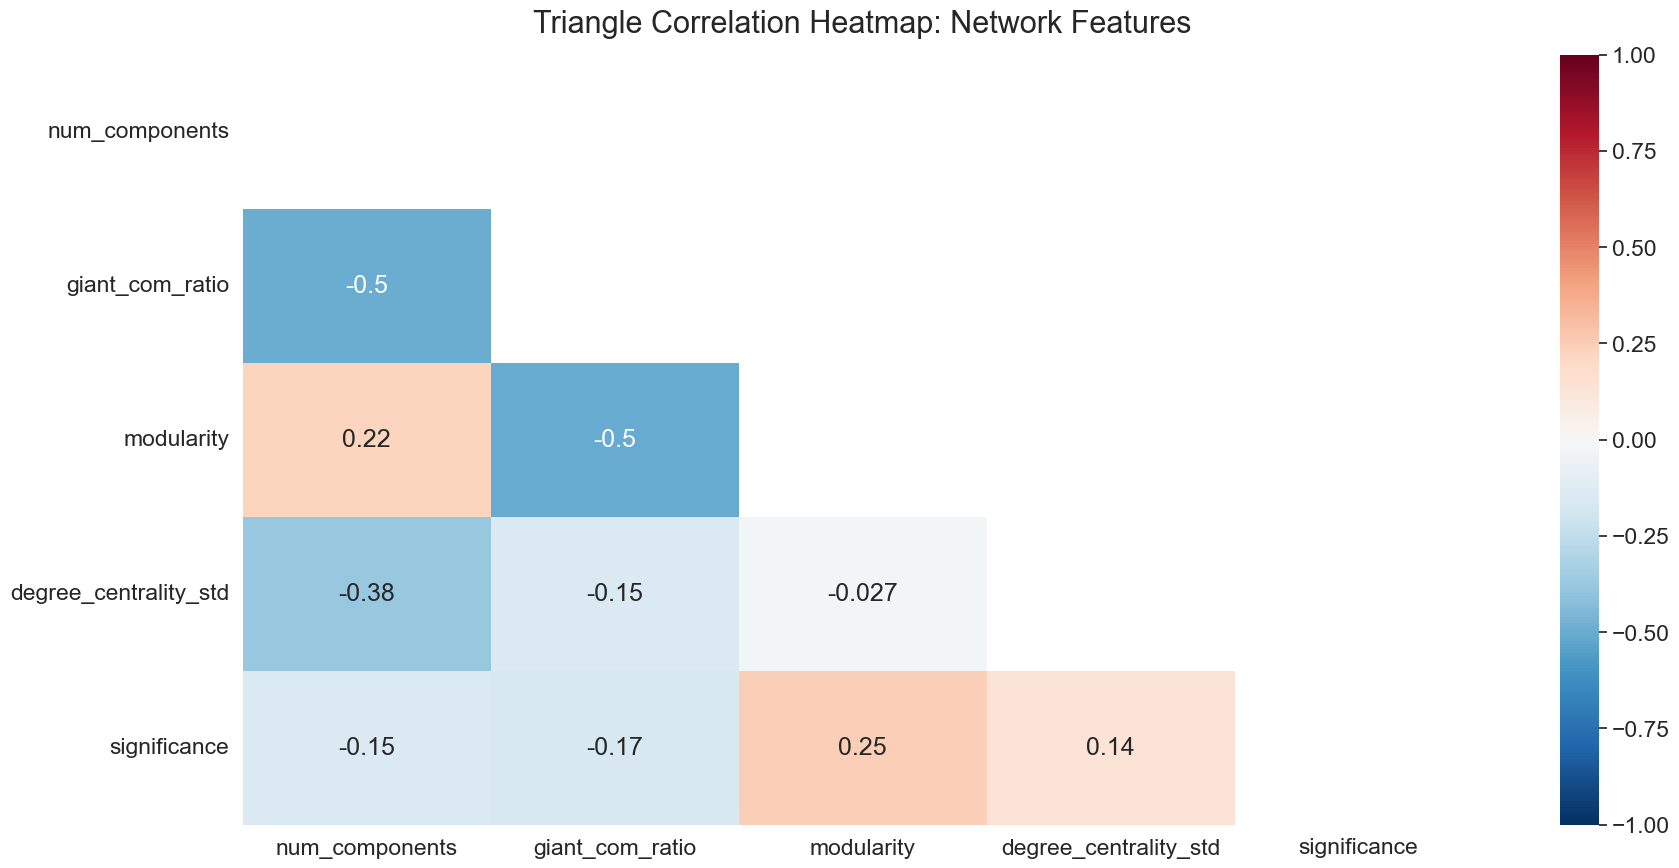

In [29]:
plt.style.use('default')
plt.figure(figsize=(20, 10))

mask = np.triu(np.ones_like(network_fea_cor, dtype=np.bool))
sns.set(font_scale=1.5) 
heatmap = sns.heatmap(network_fea_cor, mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r') #control colors: https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps/#:~:text=You%20can%20customize%20the%20colors,heatmap()%20function%20in%20seaborn.&text=It%20is%20also%20possible%20to,vmin%20parameters%20in%20the%20function.
heatmap.set_title('Triangle Correlation Heatmap: Network Features', fontdict={'fontsize':22}, pad=16);

heatmap.set_facecolor((1,1,1))
plt.savefig(f'{FIGURE_DIR}/Correlation_Heatmap')
